<h1 align="center">Volume 1: Facial Recognition.</h1>

    Garret Carver
    11 December 2018

In [24]:
import os
import numpy as np
from imageio import imread
from matplotlib import pyplot as plt
from scipy import linalg as la

### Helper Functions

In [25]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))

In [26]:
def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    a = image.reshape((m,n))
    plt.imshow(a, cmap = 'gray')
    plt.show()

(36000, 153)


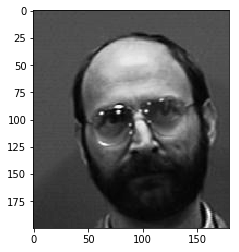

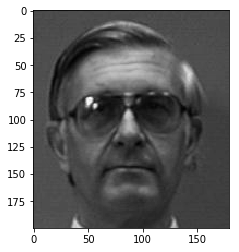

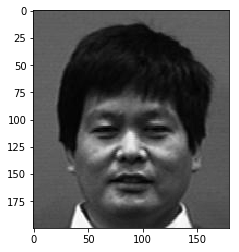

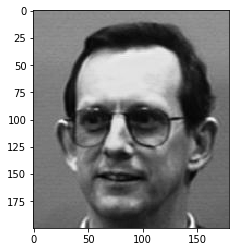

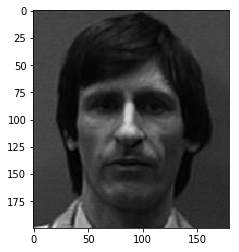

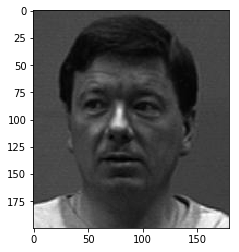

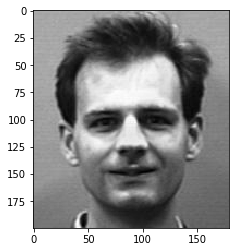

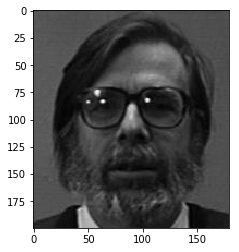

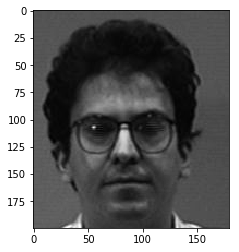

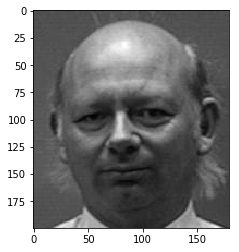

In [29]:
#check our sanity
obj = get_faces()
print(obj.shape)
for i in range(10):
    show(obj[:,i])

In [30]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """
    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        #(36000, 153) array of all faces
        self.F = get_faces(path)
        
        #calculate mean for mean shifting 
        self.mu = np.mean(self.F, axis=1)
        
        # Store mean-shifted faces i.e. "EigenFaces"
        self.Fbar = self.F - np.vstack(self.mu)
        
        #Calculate and store SVD components
        self.U,v,d = la.svd(self.Fbar, full_matrices=False)

    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        #project first s columns of U onto A
        return self.U[:,:s].T @ A

    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        Fhat = self.project(self.Fbar, s)
        ghat = self.project(g-self.mu, s)
        return np.argmin(np.linalg.norm(Fhat - np.vstack(ghat), axis=0))

    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        j = self.find_nearest(image, s)
        match = self.F[:,j]

        plt.subplot(121)
        plt.title("Input Image")
        show(image, m, n)
        
        plt.subplot(122)
        plt.title("Closest Match")
        show(match, m, n)
        
        plt.show()

### Data Visualization

- We initialize a `FacialRec` object and display its mean face, plus an original image and its shifted face.

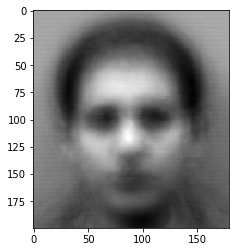

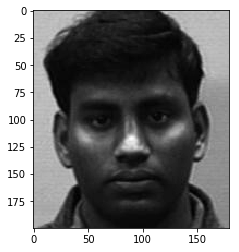

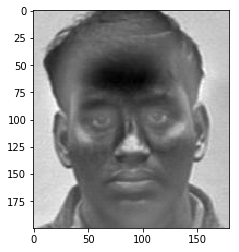

In [31]:
facial_obj = FacialRec()
#mean Face
show(facial_obj.mu)

#origininal image
show(facial_obj.F[:,150])

#shifted Face
show(facial_obj.Fbar[:,150])


### Visualizing the 'EigenFace'
- We use `show()` to display some of the eigenfaces (the columns of $U$).


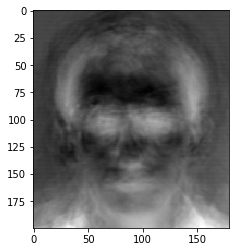

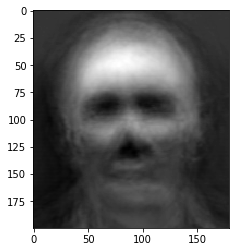

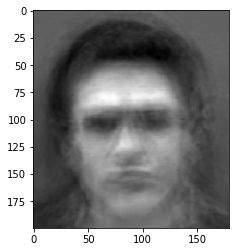

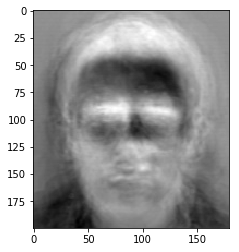

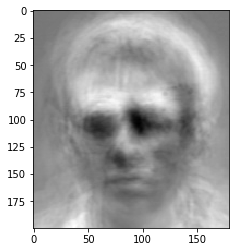

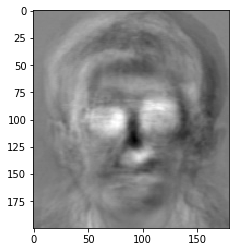

In [32]:
show(facial_obj.U[:,0])
show(facial_obj.U[:,1])
show(facial_obj.U[:,2])
show(facial_obj.U[:,3])
show(facial_obj.U[:,4])
show(facial_obj.U[:,10])

### Projections onto lower dimension

- We compute the $s$-projection $\widehat{\mathbf{f}}_i$ and then compute the reconstruction $\widetilde{\mathbf{f}}_i$.
- We do this for several values of s to validate our assumption that a smaller s value will result in more data loss.

original


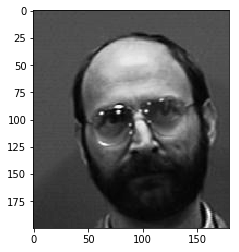

reconstructed s = 10


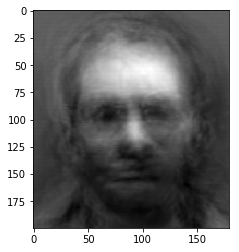

original


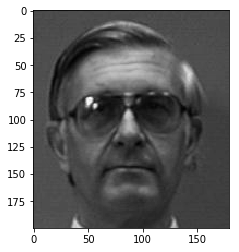

reconstructed s = 14


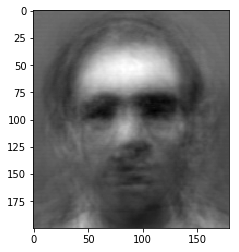

original


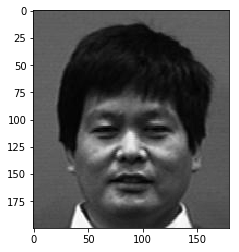

reconstructed s = 50


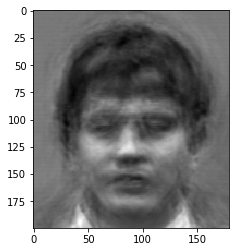

original


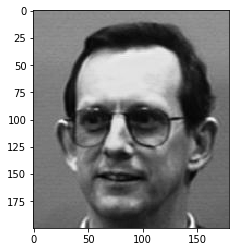

reconstructed s = 100


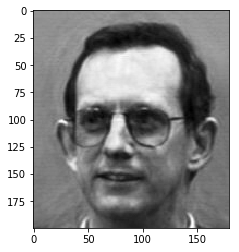

In [33]:
#k will iterate through the first 4 images
k = 0
#values of s that we will use
s_domain = [10,14,50,100]

for s in s_domain:
    print('original')
    f_bar = facial_obj.Fbar[:,k]
    show(f_bar + facial_obj.mu)
    
    print('reconstructed', 's =',s)
    f_hat = facial_obj.project(f_bar, s)
    f_squigle = facial_obj.U[:, :s] @ f_hat + facial_obj.mu
    show(f_squigle)
    k +=1

### Facial Recognition

- For some random faces in `sample_faces()`, we use `FacialRec.match()` to find the closest match (let $s=38$ to balance computation time and image quality).

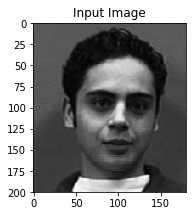

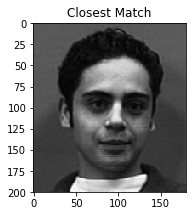

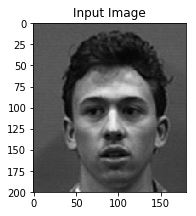

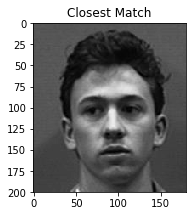

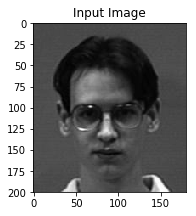

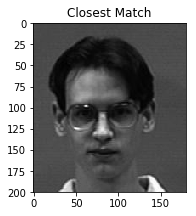

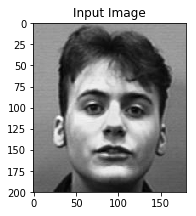

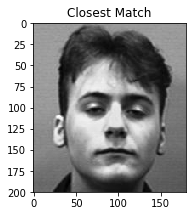

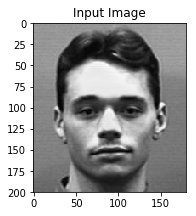

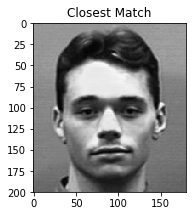

In [34]:
for test_image in sample_faces(5):
   facial_obj.match(test_image,38)